# Text mining project
## Group 12

In [36]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus.reader import ConllCorpusReader
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from gensim.models import KeyedVectors

## Loading and wrangling data

In [2]:
ner_test = pd.read_csv('NER-final-test.tsv', delimiter='\t')[['token', 'BIO NER tag']]
ner_test[['token', 'pos']] = nltk.pos_tag(ner_test['token'])

st_test = pd.read_csv('sentiment-topic-final-test.tsv', delimiter='\t').drop(columns=['sentence id'])

In [3]:
ner_train = pd.DataFrame(
    ConllCorpusReader('../Ass3/nerc_datasets/CONLL2003',
                      'train.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])
ner_val = pd.DataFrame(
    ConllCorpusReader('../Ass3/nerc_datasets/CONLL2003',
                      'valid.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])

In [4]:
v = DictVectorizer().fit([tok for l in [ner_train, ner_val, ner_test]
                          for tok in l[['token', 'pos']].T.to_dict().values()])

In [5]:
train = v.transform(ner_train[['token', 'pos']].T.to_dict().values())
val = v.transform(ner_val[['token', 'pos']].T.to_dict().values())

## Training classification models for NERC with BoW

#### SVM hyperparameter tuning and training

In [6]:
# svm = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)

# Takes forever to run so just use the params below
# svm.best_params_ = {'C': 100.0}

svm_bow = LinearSVC(C=100, max_iter=10000)
svm_bow.fit(train, ner_train['label'].values)
svm_bow_pred = svm_bow.predict(val)
print(classification_report(ner_val['label'].values, svm_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.87      0.80      0.83      1837
      B-MISC       0.88      0.74      0.80       922
       B-ORG       0.80      0.65      0.72      1341
       B-PER       0.88      0.62      0.73      1842
       I-LOC       0.72      0.70      0.71       257
      I-MISC       0.79      0.51      0.62       346
       I-ORG       0.72      0.46      0.56       751
       I-PER       0.44      0.87      0.59      1307
           O       0.99      0.99      0.99     42759

    accuracy                           0.94     51362
   macro avg       0.79      0.70      0.73     51362
weighted avg       0.95      0.94      0.94     51362



#### Naive Bayes training

In [7]:
# Naive Bayes doesn't make much sense for such a task but I wanted to have 3 classifiers and training a NN is a bit more of a hassle
nb_bow = MultinomialNB()
nb_bow.fit(train, ner_train['label'].values)
nb_bow_pred = nb_bow.predict(val)
print(classification_report(ner_val['label'].values, nb_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.43      0.87      0.58      1837
      B-MISC       0.90      0.64      0.75       922
       B-ORG       0.70      0.54      0.61      1341
       B-PER       0.81      0.62      0.70      1842
       I-LOC       0.85      0.11      0.20       257
      I-MISC       0.93      0.15      0.26       346
       I-ORG       0.60      0.42      0.50       751
       I-PER       0.73      0.35      0.48      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.92     51362
   macro avg       0.77      0.52      0.56     51362
weighted avg       0.93      0.92      0.92     51362



#### KNN hyperparameter tuning and training

In [8]:
# knn = GridSearchCV(KNeighborsClassifier(),
#                    {'n_neighbors': np.arange(2, 14, 2), 'p': [1, 2, 3]},
#                    scoring='f1_macro',
#                    n_jobs=-1)

# Takes forever to run so just use the params below
# knn.best_params_ = {'n_neighbors': 12, 'p': 1}

knn_bow = KNeighborsClassifier(n_neighbors=12, p=1, n_jobs=-1)
knn_bow.fit(train, ner_train['label'].values)
knn_bow_pred = knn_bow.predict(val)
print(classification_report(ner_val['label'].values, knn_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.82      0.70      0.76      1837
      B-MISC       0.80      0.63      0.71       922
       B-ORG       0.23      0.71      0.35      1341
       B-PER       0.86      0.37      0.52      1842
       I-LOC       0.70      0.59      0.64       257
      I-MISC       0.82      0.38      0.52       346
       I-ORG       0.76      0.32      0.45       751
       I-PER       0.64      0.14      0.23      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.91     51362
   macro avg       0.74      0.54      0.57     51362
weighted avg       0.93      0.91      0.91     51362



## Training classification models for NERC with word embeddings

In [24]:
word_embedding_model = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin', binary=True)

def to_embedding(word):
    if word != '' and word != 'DOCSTART' and word in word_embedding_model:
        return word_embedding_model[word]
    return [0]*300

In [25]:
train = np.concatenate(ner_train['token'].map(to_embedding).values).reshape(-1, 300)
val = np.concatenate(ner_val['token'].map(to_embedding).values).reshape(-1, 300)

#### SVM hyperparameter tuning and training

In [27]:
# svm_we = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)

# Takes forever to run so just use the params below
# svm.best_params_ = {'C': 10.0}

svm_we = LinearSVC(C=10, max_iter=10000)
svm_we.fit(train, ner_train['label'].values)
svm_we_pred = svm_we.predict(val)
print(classification_report(ner_val['label'].values, svm_we_pred))

C:\Users\Grazuole\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

       B-LOC       0.82      0.80      0.81      1837
      B-MISC       0.79      0.69      0.74       922
       B-ORG       0.70      0.65      0.67      1341
       B-PER       0.79      0.71      0.74      1842
       I-LOC       0.61      0.56      0.58       257
      I-MISC       0.68      0.43      0.53       346
       I-ORG       0.61      0.36      0.45       751
       I-PER       0.60      0.57      0.58      1307
           O       0.97      1.00      0.98     42759

    accuracy                           0.94     51362
   macro avg       0.73      0.64      0.68     51362
weighted avg       0.93      0.94      0.93     51362



#### KNN hyperparameter tuning and  training

In [ ]:
knn_we = GridSearchCV(KNeighborsClassifier(),
                      {'n_neighbors': np.arange(2, 14, 2), 'p': [1, 2, 3]},
                      scoring='f1_macro',
                      n_jobs=-1)
knn_we.fit(train, ner_train['label'].values)
knn_we_pred = knn_we.predict(val)
print(classification_report(ner_val['label'].values, knn_we_pred))

In [35]:
knn_we = KNeighborsClassifier()
knn_we.fit(train, ner_train['label'].values)
knn_we_pred = knn_we.predict(val)
print(classification_report(ner_val['label'].values, knn_we_pred))

              precision    recall  f1-score   support

       B-LOC       0.80      0.83      0.81      1837
      B-MISC       0.77      0.72      0.74       922
       B-ORG       0.69      0.65      0.67      1341
       B-PER       0.74      0.70      0.72      1842
       I-LOC       0.68      0.52      0.59       257
      I-MISC       0.74      0.46      0.57       346
       I-ORG       0.62      0.43      0.51       751
       I-PER       0.55      0.57      0.56      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.94     51362
   macro avg       0.73      0.65      0.68     51362
weighted avg       0.93      0.94      0.93     51362



#### Random Forest hyperparameter tuning and training

In [ ]:
rf_we = GridSearchCV(RandomForestClassifier(),
                     {'n_estimators': np.arange(50, 151, 25), 'max_depth': [5, 10, 15, None]},
                     scoring='f1_macro',
                     n_jobs=-1)
rf_we.fit(train, ner_train['label'].values)
rf_we_pred = knn_we.predict(val)
print(classification_report(ner_val['label'].values, rf_we_pred))

In [37]:
rf_we = RandomForestClassifier()
rf_we.fit(train, ner_train['label'].values)
rf_we_pred = rf_we.predict(val)
print(classification_report(ner_val['label'].values, rf_we_pred))

              precision    recall  f1-score   support

       B-LOC       0.86      0.82      0.84      1837
      B-MISC       0.87      0.71      0.78       922
       B-ORG       0.78      0.64      0.70      1341
       B-PER       0.86      0.71      0.78      1842
       I-LOC       0.71      0.69      0.70       257
      I-MISC       0.76      0.50      0.60       346
       I-ORG       0.70      0.45      0.55       751
       I-PER       0.68      0.53      0.59      1307
           O       0.96      1.00      0.98     42759

    accuracy                           0.94     51362
   macro avg       0.80      0.67      0.73     51362
weighted avg       0.94      0.94      0.94     51362



## Plots

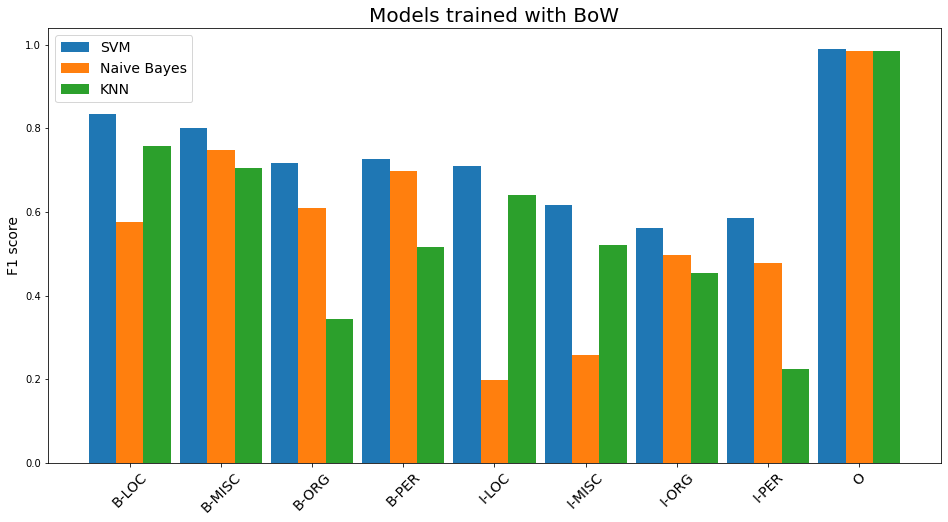

In [23]:
x = np.arange(0, 9)
plt.figure(figsize=(16, 8))
plt.bar(x - 0.3, height=f1_score(ner_val['label'], svm_bow_pred, average=None), width=0.3, label='SVM')
plt.bar(x, height=f1_score(ner_val['label'], nb_bow_pred, average=None), width=0.3, label='Naive Bayes')
plt.bar(x + 0.3, height=f1_score(ner_val['label'], knn_bow_pred, average=None), width=0.3, label='KNN')
plt.title('Models trained with BoW', fontsize=20)
plt.xticks(x, labels=sorted(ner_train.label.unique()), rotation=45, fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Plots/BoW models.png')
plt.show()

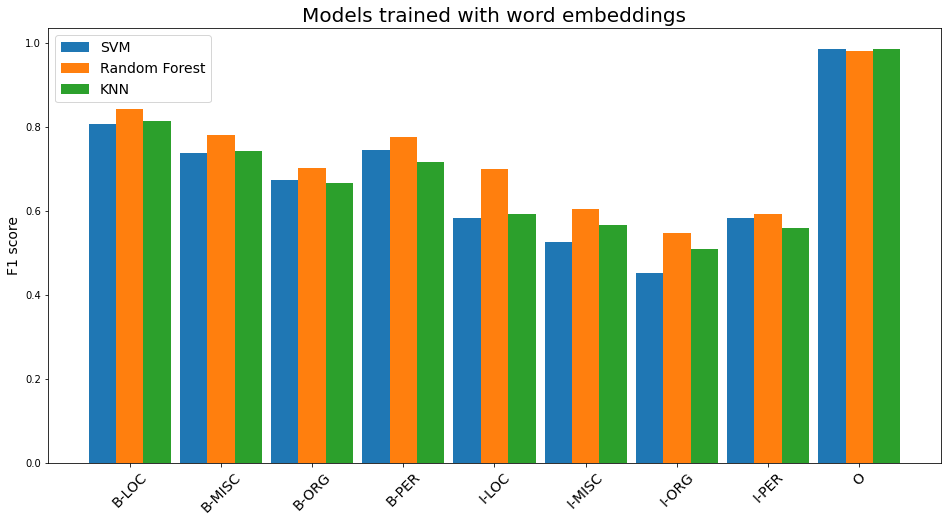

In [39]:
plt.figure(figsize=(16, 8))
plt.bar(x - 0.3, height=f1_score(ner_val['label'], svm_we_pred, average=None), width=0.3, label='SVM')
plt.bar(x, height=f1_score(ner_val['label'], rf_we_pred, average=None), width=0.3, label='Random Forest')
plt.bar(x + 0.3, height=f1_score(ner_val['label'], knn_we_pred, average=None), width=0.3, label='KNN')
plt.title('Models trained with word embeddings', fontsize=20)
plt.xticks(x, labels=sorted(ner_train.label.unique()), rotation=45, fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Plots/WE models.png')
plt.show()

## Sentiment analysis and classification

## Topic analysis and classification